In [1]:
import ephem
import matplotlib.pyplot as plt
import random
import numpy as np
random.seed()
import scipy.io



In [2]:
#detection_effeciency = 0.25

In [3]:
'''
created_pair_events = []
PAIR_EVENT_COUNT = 16e6
event_rate = 16e6 # the lambda
for i in range (int(PAIR_EVENT_COUNT) ):
    created_pair_events.append( random.expovariate(event_rate) )
'''

'\ncreated_pair_events = []\nPAIR_EVENT_COUNT = 16e6\nevent_rate = 16e6 # the lambda\nfor i in range (int(PAIR_EVENT_COUNT) ):\n    created_pair_events.append( random.expovariate(event_rate) )\n'

In [4]:
#sum(created_pair_events)

In [5]:
#created_pair_events[:10]

In [6]:
#time_series_pair_events = np.cumsum(created_pair_events)



In [7]:
def lossy_channel(events_list,transmission_factor):
    channel_effeciency = transmission_factor
    r = []
    for event in events_list:
        if random.random() < channel_effeciency:
            r.append(event)
    return r


In [8]:
def detect_event(input_events_list, detection_effeciency):
    return lossy_channel(input_events_list,detection_effeciency)


In [9]:
#signal_singles = detect_event(time_series_pair_events,detection_effeciency)
#idler_singles =  detect_event(time_series_pair_events,detection_effeciency)

In [10]:
#ss_Set = set(signal_singles)
#is_Set = set(idler_singles)

In [11]:
#coincidence = ss_Set.intersection(is_Set)

In [12]:
def _data_extractor(filename):
    """Reads raw timestamp into time and patterns vectors

    :param filename: a python file object open in binary mode
    :type filename: _io.BufferedReader
    :returns: Two vectors: timestamps, corresponding pattern
    :rtype: {numpy.ndarray(float), numpy.ndarray(uint32)}
    """
    with open(filename, 'rb') as f:
        data = np.fromfile(file=f, dtype='=I').reshape(-1, 2)
        # cast to uint64!!!
        t = ((np.uint64(data[:, 0]) << 17) + (data[:, 1] >> 15)) / 8. # time in nanoseconds. 
        #t = ((np.uint64(data[:, 0]) << 17) + (data[:, 1] >> 15)) 
        p = data[:, 1] & 0xf
        return t, p


In [13]:
file ="/home/odin/work/gProj/clockSyncLEO/TimeStampData/13Nov18/10KM_2018-06-20T17-33-20-224820.txt"

In [14]:
t,p = _data_extractor(file)

In [15]:
t

array([3.91143688e+06, 3.92457625e+06, 3.97981688e+06, ...,
       2.99915917e+11, 2.99916072e+11, 2.99916074e+11])

In [16]:
p

array([1, 2, 1, ..., 2, 1, 2], dtype=uint32)

In [17]:
alice_filter = np.bitwise_and(p,2) == 2

In [18]:
A_event = np.extract(alice_filter, t)

In [19]:
len(A_event)

6430665

In [20]:
unique, counts = np.unique(p, return_counts=True)
d= dict(zip(unique, counts))

In [21]:
d

{1: 4634679, 2: 6429484, 3: 1181}

In [22]:
t[0] * 1e-9

0.003911436875

In [23]:
t[1] * 1e-9

0.003924576250000001

In [24]:
bob_filter = np.bitwise_and(p,1) == 1

In [25]:
B_event = np.extract(bob_filter,t)

In [26]:
len(B_event)

4635860

In [27]:
my_loc = ephem.Observer()
my_loc.lat = '1.2954752'
my_loc.lon = '103.7800079'
my_loc.elevation = 100

In [28]:
name = 'GALASSIA'
line1 = '1 41170U 15077E   18291.47886069  .00002035  00000-0  73075-4 0  9998'
line2 = '2 41170  14.9881 191.7979 0013088 334.9563  25.0122 15.13422614157130'
my_sat = ephem.readtle(name,line1,line2)

In [29]:
info=my_loc.next_pass(my_sat)

In [30]:
info

(43430.70223943248,
 4.2964324951171875,
 43430.63619577556,
 0.35761284828186035,
 43430.6403598913,
 1.7430438995361328)

In [31]:
ephem.second

1.1574074074074073e-05

In [32]:
ephem.c

299792458.0

In [33]:
start_time = ephem.Date('2018/10/19 04:53:01') +ephem.second * 75

In [34]:
r_list = [] # range list
t_list = []

for t in B_event:
    ts = t * 1e-9
    d_time = ephem.Date(start_time + (ephem.second * ts  ) )
    my_loc.date = d_time
    my_sat.compute(my_loc)
    
    r_list.append(my_sat.range)
    t_list.append(d_time)
    

In [35]:
len(r_list)

4635860

In [36]:
r_list_10km_removed = [x-10e3 for x in r_list]

In [37]:
r_list_10km_removed[0]

1885384.0

In [38]:
r_list[0]

1895384.0

In [39]:
t_delta_list = [(x / ephem.c)*1e9 for x in r_list_10km_removed]

In [40]:
t_delta_list[0]

6288964.080610727

In [41]:
B_event_doppler_shifted_no_loss = [x+y for (x,y) in zip(t_delta_list,B_event)]

In [42]:
np.savetxt("Bob_no_channel_loss_with_doppler.csv", B_event_doppler_shifted_no_loss, delimiter=",")

In [43]:
scipy.io.savemat('Bob_no_channel_loss_with_doppler.mat', mdict={'BobTimestamps': B_event_doppler_shifted_no_loss})

In [44]:
scipy.io.savemat('Alice_timestamps.mat', mdict={'AliceTimestamps': A_event})

In [45]:
Bob_event_doppler_30db = lossy_channel(B_event_doppler_shifted_no_loss, 0.001) # 30dB loss

In [46]:
Bob_event_doppler_40db = lossy_channel(B_event_doppler_shifted_no_loss, 0.0001) # 30dB loss

In [47]:
scipy.io.savemat('Bob_30dB_channel_loss_with_doppler.mat', mdict={'BobTimestamps30dBLoss': Bob_event_doppler_30db})

In [48]:
scipy.io.savemat('Bob_40dB_channel_loss_with_doppler.mat', mdict={'BobTimestamps40dBLoss': Bob_event_doppler_40db})

In [54]:
scipy.io.savemat('Bob_timestamps_No_Doppler_0dB.mat', mdict={'BobTimestampsnoDoppler': B_event})

In [49]:
len(Bob_event_doppler_30db)

4636

In [50]:
len(Bob_event_doppler_40db)

489

In [51]:
nt_list = [(x - start_time)*24*60*60 for x in t_list]
rkm_list = [x/1000 for x in r_list] 

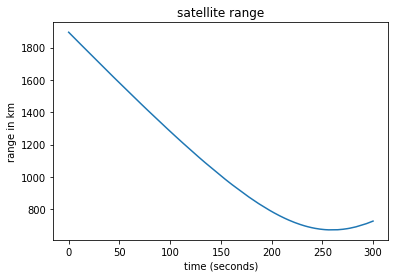

In [52]:
plt.plot(nt_list,rkm_list, label="GALASSIA")
plt.title('satellite range')
plt.xlabel("time (seconds)")
plt.ylabel('range in km')
plt.savefig("range.png") 
plt.show()